# 인공지능적사고와문제해결 프로젝트2 8조

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import lightgbm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [2]:
# set options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# 예측한 값으로 성능을 평가하는 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred) # 오차 행렬
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    f1 = f1_score(y_test, pred) # F1
    roc_auc = roc_auc_score(y_test, pred_proba) # ROC-AUC
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## 데이터 전처리

In [4]:
vote_df = pd.read_csv("C:\\Users\kimsj\\OneDrive\\바탕 화면\\대학교\\git\\AI-project\\data\\train.csv", encoding="utf-8")
test_df = pd.read_csv("C:\\Users\kimsj\\OneDrive\\바탕 화면\\대학교\\git\\AI-project\\data\\test.csv", encoding="utf-8")
print("dataset shape: ", vote_df.shape)
print("dataset shape: ", test_df.shape)

# 인덱스 제거
vote_df.drop("index", axis=1, inplace=True)
test_index = test_df["index"]
test_df.drop("index", axis=1, inplace=True)

dataset shape:  (36425, 78)
dataset shape:  (9107, 77)


In [5]:
# 0값을 검사할 피처명 리스트 객체 설정
# zero_features = ['education', 'engnat', 'hand', 'urban']
# education 비율 맞추기?
zero_features = []

# tp 추가
for i in range(1, 11):
    s = 'tp' + chr(48+(i//10)) + chr(48+(i%10))
    zero_features.append(s)
    
# zero_features 리스트 내부에 저장된 개별 피처들에 대해 0값을 평균 값으로 대체
vote_df[zero_features] = vote_df[zero_features].replace(0, vote_df[zero_features].mean())
test_df[zero_features] = test_df[zero_features].replace(0, test_df[zero_features].mean())

### 인코딩

In [6]:
# 레이블 인코딩
encoder = LabelEncoder()
encoder_test = LabelEncoder()

encoder.fit(vote_df['age_group'])
encoder_test.fit(test_df['age_group'])
labels = encoder.transform(vote_df['age_group'])
labels_test = encoder_test.transform(test_df['age_group'])

vote_df['age_group'] = labels
test_df['age_group'] = labels_test

def get_categoty_age(age_num):
    num = age_num;
    if age_num == 0: num =7

    return num

vote_df["age_group"] = vote_df["age_group"].apply(lambda x : get_categoty_age(x))
test_df["age_group"] = test_df["age_group"].apply(lambda x : get_categoty_age(x))

# 원핫 인코딩
def dummy_data(data, columns) :
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data

dummy_columns = ['engnat', 'gender','hand', 'married', 'race', 'religion', 'urban']
# wr 추가
for i in range(1, 14):
    s = 'wr_' + chr(48+(i//10)) + chr(48+(i%10))
    dummy_columns.append(s)
# wf 추가
for i in range(1, 4):
    s = 'wf_' + chr(48+(i//10)) + chr(48+(i%10))
    dummy_columns.append(s)
# print(dummy_columns)

vote_df = dummy_data(vote_df, dummy_columns)
test_df = dummy_data(test_df, dummy_columns)


### 이상값 처리

In [7]:
# 시간 데이터 전처리

#Q_E 시간
Q_E = []
for i in range(97, 117):
    a = 'Q' + chr(i) + 'E'
    Q_E.append(a)

def get_categoty_time(Q_time):
    cat = 0
    if Q_time <= 1000 : cat = 1
    elif Q_time <= 2000 : cat = 2
    elif Q_time <= 3000 : cat = 3
    elif Q_time <= 4000 : cat = 4
    elif Q_time <= 5000 : cat = 5
    elif Q_time <= 6000 : cat = 6
    elif Q_time <= 7000 : cat = 7
    elif Q_time <= 8000 : cat = 8
    elif Q_time <= 9000 : cat = 9
    elif Q_time <=10000 : cat = 10
    elif Q_time <=15000 : cat = 11
    elif Q_time <=20000 : cat = 12
    else : Q_time = 13

    return cat

for Q_time in Q_E:
    vote_df[Q_time] = vote_df[Q_time].apply(lambda x : get_categoty_time(x))
    test_df[Q_time] = test_df[Q_time].apply(lambda x : get_categoty_time(x))


In [8]:
# 이상치 데이터 제거
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['voted']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index    
    return outlier_index

# train data: race_White, religion_Agnostic  religion_Atheist  
outlier_index = get_outlier(df=vote_df, column="race_White", weight=1.5)
vote_df.drop(outlier_index, axis=0, inplace=True)

outlier_index = get_outlier(df=vote_df, column="religion_Agnostic", weight=1.5)
vote_df.drop(outlier_index, axis=0, inplace=True)

outlier_index = get_outlier(df=vote_df, column="religion_Atheist", weight=1.5)
vote_df.drop(outlier_index, axis=0, inplace=True)

## 모델 학습

In [9]:
# label/feature 분리 및 학습세트/평가세트 분리
y_labels = vote_df.loc[:,'voted']
X_features = vote_df.drop('voted', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=156)

# 분포 비율 확인
train_cnt = y_train.count()
test_cnt = y_test.count()

print("학습 세트 Shape:{0}, 테스트 세트 Shape:{1}".format(X_train.shape, X_test.shape))
print(" 학습 세트 레이블 값 분포 비율")
print(y_train.value_counts()/train_cnt)
print("\n 테스트 세트 레이블 값 분포 비율")
print(y_test.value_counts()/test_cnt)
print()

# 데이터 정규화(스케일링)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

test_sc = scaler.transform(test_df) # test data scaling

#undersampling
under_sampler = RandomUnderSampler(random_state=156)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

# # smote oversampling
# smote = SMOTE(random_state=156)
# X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# 학습
evals = [(X_test, y_test)]
xgb_model = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, objective="binary:logistic", random_state=156)
xgb_model.fit(X_train_under, y_train_under, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
preds = xgb_model.predict(X_test)
pred_proba = xgb_model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, preds, pred_proba)

학습 세트 Shape:(23740, 121), 테스트 세트 Shape:(5935, 121)
 학습 세트 레이블 값 분포 비율
0    0.669966
1    0.330034
Name: voted, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.676158
1    0.323842
Name: voted, dtype: float64

[0]	validation_0-logloss:0.64745
[1]	validation_0-logloss:0.61123
[2]	validation_0-logloss:0.58163
[3]	validation_0-logloss:0.55718
[4]	validation_0-logloss:0.53683
[5]	validation_0-logloss:0.51990
[6]	validation_0-logloss:0.50516
[7]	validation_0-logloss:0.49285


C:\Users\kimsj\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-logloss:0.48124
[9]	validation_0-logloss:0.47214
[10]	validation_0-logloss:0.46336
[11]	validation_0-logloss:0.45619
[12]	validation_0-logloss:0.45014
[13]	validation_0-logloss:0.44411
[14]	validation_0-logloss:0.43925
[15]	validation_0-logloss:0.43506
[16]	validation_0-logloss:0.43126
[17]	validation_0-logloss:0.42805
[18]	validation_0-logloss:0.42521
[19]	validation_0-logloss:0.42214
[20]	validation_0-logloss:0.41987
[21]	validation_0-logloss:0.41751
[22]	validation_0-logloss:0.41572
[23]	validation_0-logloss:0.41412
[24]	validation_0-logloss:0.41243
[25]	validation_0-logloss:0.41114
[26]	validation_0-logloss:0.40999
[27]	validation_0-logloss:0.40877
[28]	validation_0-logloss:0.40784
[29]	validation_0-logloss:0.40700
[30]	validation_0-logloss:0.40614
[31]	validation_0-logloss:0.40530
[32]	validation_0-logloss:0.40457
[33]	validation_0-logloss:0.40402
[34]	validation_0-logloss:0.40340
[35]	validation_0-logloss:0.40292
[36]	validation_0-logloss:0.40242
[37]	validation_

C:\Users\kimsj\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


### 테스트 데이터 예측

In [97]:
xgb_model_test = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, objective="binary:logistic", random_state=156)
pred_proba
num = 150
for i in range(150):
    xgb_model_test.fit(X_features.sample(9107), y_labels.sample(9107))
    pred_proba += xgb_model_test.predict_proba(test_sc)[:,1]
    
pred_proba_test = pred_proba/num

test_submission = pd.DataFrame({"index" : test_index,
                                "pred_prob" : pred_proba_test,
                                "pred" : preds_test})

[19:02:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:02:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:02:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:02:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[19:04:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:04:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:04:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:04:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[19:06:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:06:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:06:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:06:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[19:09:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:09:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:09:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:09:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[19:11:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:11:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:11:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:12:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[19:14:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:14:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:14:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:14:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [98]:
X_train_under.shape

(15670, 121)

In [117]:
num1 = 0;

for i in range(test_submission.shape[0]):
        num1 += test_submission['pred_prob'][i]
print(num1/test_submission.shape[0])

num2 = 0;

for i in range(test_submission.shape[0]):
    if (test_submission['pred_prob'][i]) > (num1/test_submission.shape[0]):
        num2 +=1
        test_submission['pred'][i] = 1
    else: test_submission['pred'][i] = 0
print(num2)

0.36418929816509715


<ipython-input-117-e63885d77495>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_submission['pred'][i] = 1
<ipython-input-117-e63885d77495>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else: test_submission['pred'][i] = 0


4048


In [118]:
test_submission.to_csv("C:\\Users\kimsj\\OneDrive\\바탕 화면\\대학교\\git\\AI-project\\experiment\\test_submission.csv", index = False)

In [119]:
# 결과 확인
test_result_df = pd.read_csv("C:\\Users\kimsj\\OneDrive\\바탕 화면\\대학교\\git\\AI-project\\experiment\\test_submission.csv", encoding="utf-8")
test_result_df.head(10)

,index,pred_prob,pred
0,38741,0.364257,1
1,43904,0.360091,0
2,41036,0.362270,0
3,6939,0.397229,1
4,14682,0.363157,0
5,35469,0.364777,1
6,33948,0.375901,1
7,3082,0.350516,0
8,33291,0.363476,0
9,32694,0.364164,0


### feature selection

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

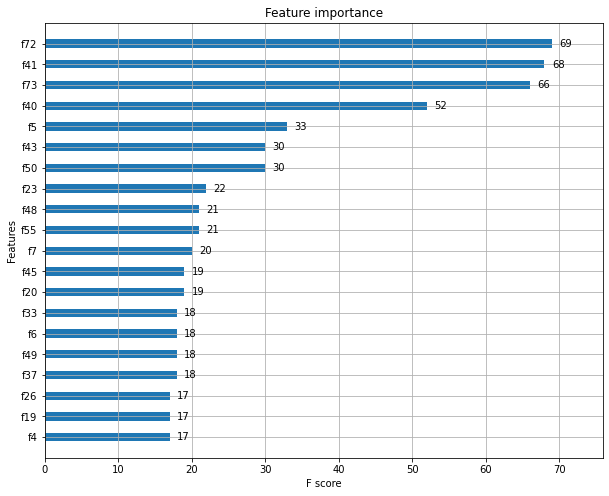

In [35]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(xgb_model, ax=ax, max_num_features=20, height=0.4)